# 날씨 빅데이터콘테스트
[날씨 빅데이터 콘테스트]https://bd.kma.go.kr/contest/sub_04.do <br>
[날씨마루] https://bd.kma.go.kr/kma2019/dta/reqst/KBP51001.do?pageNum=5&menuCd=F040201020 <br>
[구글드라이브-데이터]https://drive.google.com/drive/folders/1RO_tBYRFGi-nXWX1Ujb4c8h6gebuCAfp <br>
[기상자료 개방포털] https://data.kma.go.kr/data/grnd/selectAsosRltmList.do?pgmNo=36&tabNo=1 <br>

### 분석 주제
공장 내 철강 제품의 결로 발생 예측 모형 개발
* 24, 48시간 후 결로 발생 예측 및 예측경보 시스템 운영방안 제시

### 분석 데이터
1. 기상데이터
    * 날씨마루, 기상자료개방 포털
2. 현대제철 공장 (당진1공장, 당진2공장)
    * 결로발생여부 : 내/외부 기온, 습도, 코일온도 
        * 1: 발생, 0:미발생
    * 데이터 기간 : 2016.4.1 ~ 2020.3.31
    
### 정확도 검증
* 2019.4.1 ~ 2020.3.31 중 특정시점 기준 24,48시간 후 결로발생 여부 (0,1)

### 테이블 설명
* plant1_train
    * 공장1의 결로발생 데이터(학습용)
    * 기간 : 2016-04-01 0:00 ~ 2019-03-31 23:50
* plant2_train
    * 공장2의 결로발생 데이터(학습용)
    * 기간 : 2016-04-01 0:00 ~ 2019-03-31 23:50
* plant_test
    * 검증용 데이터
    * 2019-04-01 0:00 ~ 2020-03-31 23:50
    * 예측 정확도 검증을 위한 결로발생 여부  비공개

### study기록 (5/23)
* 이슬점 : 온도와 상대습도로 구할수 있는 값
    * 코일 표면온도랑 이슬점 온도 비교 : 코일온도가 이슬점온도보다 낮을경우 결로가 생김. 
        * but, 코일온도가 이슬점온도보다 높아도 결로는 생김. 
 * 코일온도와 이슬점온도 차이 분포
     * 결로가 안생겼을때 min은 0.98
     * 결로가 생겼을때 max는 1
         * 결론은, 코일온도가 이슬점온도보다 높을때도 결로는 생기지만, 그때의 코일온도와 이슬점온도 차이는 크지않으므로 오차로볼수도 있음. 
* 강수량 데이터 참고필요
* 요일별로 결로 확인 
* 결로 측정이 사람이 해야알수있는건지, 아니면 기계가 자동으로 결로인걸 파악하는건지 
* 모델링은 회귀..?

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
from itertools import cycle
%matplotlib inline
pd.options.mode.chained_assignment = None  # default='warn'

pd.set_option('max_columns', 50)
plt.style.use('bmh')
color_pal = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])

In [2]:
# jupyter notebook cell 너비 조절
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

import warnings
warnings.filterwarnings("ignore")

In [3]:
# # 주피터 다크모드에서 제목, x축,y축 잘보이게
# from jupyterthemes import jtplot
# jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)

In [4]:
# 한글깨짐 문제
import matplotlib.pyplot as plt
from matplotlib import rc
rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

데이터 불러오기

In [9]:
plant1_train=pd.read_csv('./data/plant1_train.csv',index_col=[0],parse_dates=['plant1_train.mea_ddhr'])
plant2_train=pd.read_csv('./data/plant2_train.csv',index_col=[0],parse_dates=['plant2_train.mea_ddhr'])
plant_test=pd.read_csv('./data/plant_test.csv',index_col=[0],parse_dates=['plant_test.mea_ddhr'])

# 당진
dangjin_humid=pd.read_csv('./data/dangjin_humid.csv',index_col=[0])
dangjin_rain=pd.read_csv('./data/dangjin_rain.csv',index_col=[0])
dangjin_tem=pd.read_csv('./data/dangjin_tem.csv',index_col=[0])

# 신평
shinpyung_humid=pd.read_csv('./data/shinpyung_humid.csv',index_col=[0])
shinpyung_rain=pd.read_csv('./data/shinpyung_rain.csv',index_col=[0])
shinpyung_tem=pd.read_csv('./data/shinpyung_tem.csv',index_col=[0])

#aws=pd.read_csv('./data/aws.csv',index_col=[0])
#forecast=pd.read_csv('./data/forecast.csv',index_col=[0])
# 서산
#seasan=pd.read_csv('./data/seosan.csv',index_col=[0])

# test데이터셋과 동일하게 train 데이터 전처리
plant_train=pd.read_csv('./data/plant_train.csv',index_col=[0])

In [16]:
dangjin_tem.head()

,aws_hr_ta.aws_id,aws_hr_ta.ta,aws_hr_ta.ta_hmi,aws_hr_ta.ta_avg,aws_hr_ta.ta_qcm,aws_hr_ta.ta_max,aws_hr_ta.ta_max_mi,aws_hr_ta.ta_min,aws_hr_ta.ta_min_mi
aws_hr_ta.tm,,,,,,,,,
2016-04-05 10:00:00.0,616,13.3,0.0,11.9,60,13.3,-4.0,10.4,NaN
2016-04-05 11:00:00.0,616,14.9,0.0,14.1,60,15.3,-12.0,13.3,NaN
2016-04-07 20:00:00.0,616,10.9,0.0,11.2,60,11.7,-59.0,10.9,NaN
2016-04-13 19:00:00.0,616,15.2,0.0,16.6,60,18.2,-59.0,15.1,NaN
2016-04-18 22:00:00.0,616,8.2,0.0,8.7,60,9.2,-59.0,8.2,NaN


In [12]:
dangjin_humid

,aws_hr_hm.aws_id,aws_hr_hm.hm,aws_hr_hm.hm_hmi,aws_hr_hm.hm_avg,aws_hr_hm.hm_qcm,aws_hr_hm.hm_max,aws_hr_hm.hm_max_mi,aws_hr_hm.hm_min,aws_hr_hm.hm_min_mi
aws_hr_hm.tm,,,,,,,,,
2016-04-02 03:00:00.0,616,54.3,0.0,52.2,60,54.6,-2.0,49.1,NaN
2016-04-05 12:00:00.0,616,18.2,0.0,19.4,60,24.5,-56.0,15.6,NaN
2016-04-05 16:00:00.0,616,23.2,0.0,22.0,60,24.9,-20.0,17.5,NaN
2016-04-07 14:00:00.0,616,51.8,0.0,56.3,60,62.2,-59.0,51.8,NaN
2016-04-09 04:00:00.0,616,92.3,0.0,92.3,60,92.3,-59.0,92.3,NaN
...,...,...,...,...,...,...,...,...,...
2020-03-21 19:00:00.0,616,79.7,0.0,77.1,60,79.7,0.0,73.4,NaN
2020-03-28 10:00:00.0,616,30.4,0.0,32.6,60,35.8,-28.0,30.1,NaN
2020-03-29 20:00:00.0,616,54.1,0.0,47.0,60,54.1,0.0,39.1,NaN


컬럼명 전처리

In [124]:
plant1_train.columns=plant1_train.columns.str.slice(13)
plant2_train.columns=plant2_train.columns.str.slice(13)
plant_test.columns=plant_test.columns.str.slice(11)

In [40]:
'plant1_train.tem_in_loc1'.split('.')[1] 

'tem_in_loc1'

In [105]:
# 공장 컬럼명 정리
plants = [plant1_train, plant2_train]

for p in plants:
    p.columns = [col.split('.')[1] for col in p.columns]
    p.rename({'mea_ddhr':'datetime', 'tem_out_loc1':'tem_out', 'hum_out_loc1':'hum_out'}, inplace=True, axis=1)

#### train데이터를 test데이터 형식에 맞게 변형

In [15]:
### junam's code
def melt_df ( data ):
    col = data.columns
    col_dict = {}
    value_dict = {}
    
    for n in col[1:]:
        n_tmp = n[13:-5]
        if n_tmp in col_dict: col_dict[n_tmp].append( n )
        else: col_dict[n_tmp] = ['time' , n]
            
    for key , col in col_dict.items():
        value_dict[key] = ['time'] + list(range( 1 , len(col)))
    # 컬럼 묶음 만들기..

    
    # 이름에 맞는 컬럼 melt하여 병합하기
    for text in col_dict:
        test = data.copy()
        test = test[col_dict[ text ]]
        test.columns = value_dict[ text ]

        add = test.melt( id_vars = test.columns[0] , var_name = 'location' , value_name = text )
        try:
            res = pd.merge( res , add , left_on = ['time','location'] , right_on = ['time','location'] , how ='outer')
        except:
            res = add

    res['plant'] = col[1][5] # plant이름넣기

    return res

In [107]:
loc_list=['loc1', 'loc2', 'loc3']
loc_list

['loc1', 'loc2', 'loc3']

In [96]:
loc_list=['loc1', 'loc2', 'loc3']
loc_cols_dict = {} 
loc_df_list = [] 
for key in loc_list:
    loc_cols_dict[key]=['datetime', 'tem_out', 'hum_out'] + [col for col in plant1_train.columns if key in col]
print(loc_cols_dict)

{'loc1': ['datetime', 'tem_out', 'hum_out', 'tem_in_loc1', 'hum_in_loc1', 'tem_coil_loc1', 'cond_loc1'], 'loc2': ['datetime', 'tem_out', 'hum_out', 'tem_in_loc2', 'hum_in_loc2', 'tem_coil_loc2', 'cond_loc2'], 'loc3': ['datetime', 'tem_out', 'hum_out', 'tem_in_loc3', 'hum_in_loc3', 'tem_coil_loc3', 'cond_loc3']}


In [98]:
for col in loc_cols_dict.values():
    print(col)

['datetime', 'tem_out', 'hum_out', 'tem_in_loc1', 'hum_in_loc1', 'tem_coil_loc1', 'cond_loc1']
['datetime', 'tem_out', 'hum_out', 'tem_in_loc2', 'hum_in_loc2', 'tem_coil_loc2', 'cond_loc2']
['datetime', 'tem_out', 'hum_out', 'tem_in_loc3', 'hum_in_loc3', 'tem_coil_loc3', 'cond_loc3']


In [ ]:
### hyunsu's code
# melt 사용한 것보다 깔끔하고 시간도 훨씬 빠름.
def pre_train(df, plant_num, loc_list):
    '''
    loc별로 컬럼이 여러개 있던 plant train 데이터를 test형식처럼 깔끔하게 만드는 함수
    
    *arrs
    df : DataFrame. plant train df
    plant_num : 공장번호
    loc_list : list. 원하는 loc별로 선택 가능.
    '''
    
    loc_cols_dict = {}  # loc별로 나눈 컬럼
    loc_df_list = []    # loc별로 나눈 df
    
    for key in loc_list:
        loc_cols_dict[key] = ['datetime', 'tem_out', 'hum_out'] + [col for col in df.columns if key in col]
        
        for col in loc_cols_dict.values():
            res = df[col]
            res['loc'] = int(key[-1])    # loc1, loc2,loc3을 1,2,3 으로
            res.columns = [x.replace(f'_{key}', '') for x in res.columns]
            
        loc_df_list.append(res)
    
    df = pd.concat(loc_df_list, axis=0).reset_index(drop=True)
    df['plant'] = plant_num
    
    return df

------------------------------------------------------------------------------------------
# EDA
## 1) plant1 데이터탐색

In [8]:
# 데이터 타입 확인
plant1_train.dtypes.to_frame().rename(columns={0:'data_types'})

,data_types
mea_ddhr,datetime64[ns]
tem_in_loc1,float64
hum_in_loc1,float64
tem_coil_loc1,float64
tem_in_loc2,float64
hum_in_loc2,float64
tem_coil_loc2,float64
tem_in_loc3,float64
hum_in_loc3,float64
tem_coil_loc3,float64


### 결측치 확인

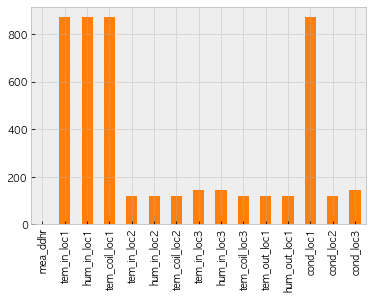

In [6]:
plant1_train.isnull().sum().plot.bar(color=color[1])

**결측치 수, 결측치 비율**

In [7]:
missing_values=pd.concat([plant1_train.isnull().sum(), 
                          round((plant1_train.isnull().sum()/plant1_train.shape[0])*100,2).to_frame().rename(columns={0:'ratio'})], axis=1)
missing_values.columns=['missing_num','ratio']
missing_values

,missing_num,ratio
mea_ddhr,0,0.00
tem_in_loc1,870,1.48
hum_in_loc1,870,1.48
tem_coil_loc1,870,1.48
tem_in_loc2,120,0.20
hum_in_loc2,120,0.20
tem_coil_loc2,120,0.20
tem_in_loc3,145,0.25
hum_in_loc3,145,0.25
tem_coil_loc3,120,0.20


* 결측치 비율이 거의 다 2%미만이고, 그나마 많은게 tem_in_loc1, hum_in_loc1, tem_coil_loc1, cond_loc1 정도

### 컬럼 별 분포 

In [8]:
plant1_var=plant1_train.iloc[:,1:12]
plant1_var.head()

,tem_in_loc1,hum_in_loc1,tem_coil_loc1,tem_in_loc2,hum_in_loc2,tem_coil_loc2,tem_in_loc3,hum_in_loc3,tem_coil_loc3,tem_out_loc1,hum_out_loc1
1,16.0,24.0,11.0,14.0,23.0,11.0,13.0,32.0,10.0,9.0,42.0
2,14.0,28.0,10.0,12.0,32.0,9.0,11.0,42.0,7.0,7.0,59.0
3,13.0,33.0,10.0,11.0,37.0,9.0,10.0,44.0,7.0,6.0,56.0
4,13.0,33.0,10.0,11.0,35.0,9.0,10.0,41.0,8.0,18.0,30.0
5,16.0,28.0,10.0,15.0,27.0,11.0,14.0,30.0,9.0,18.0,20.0


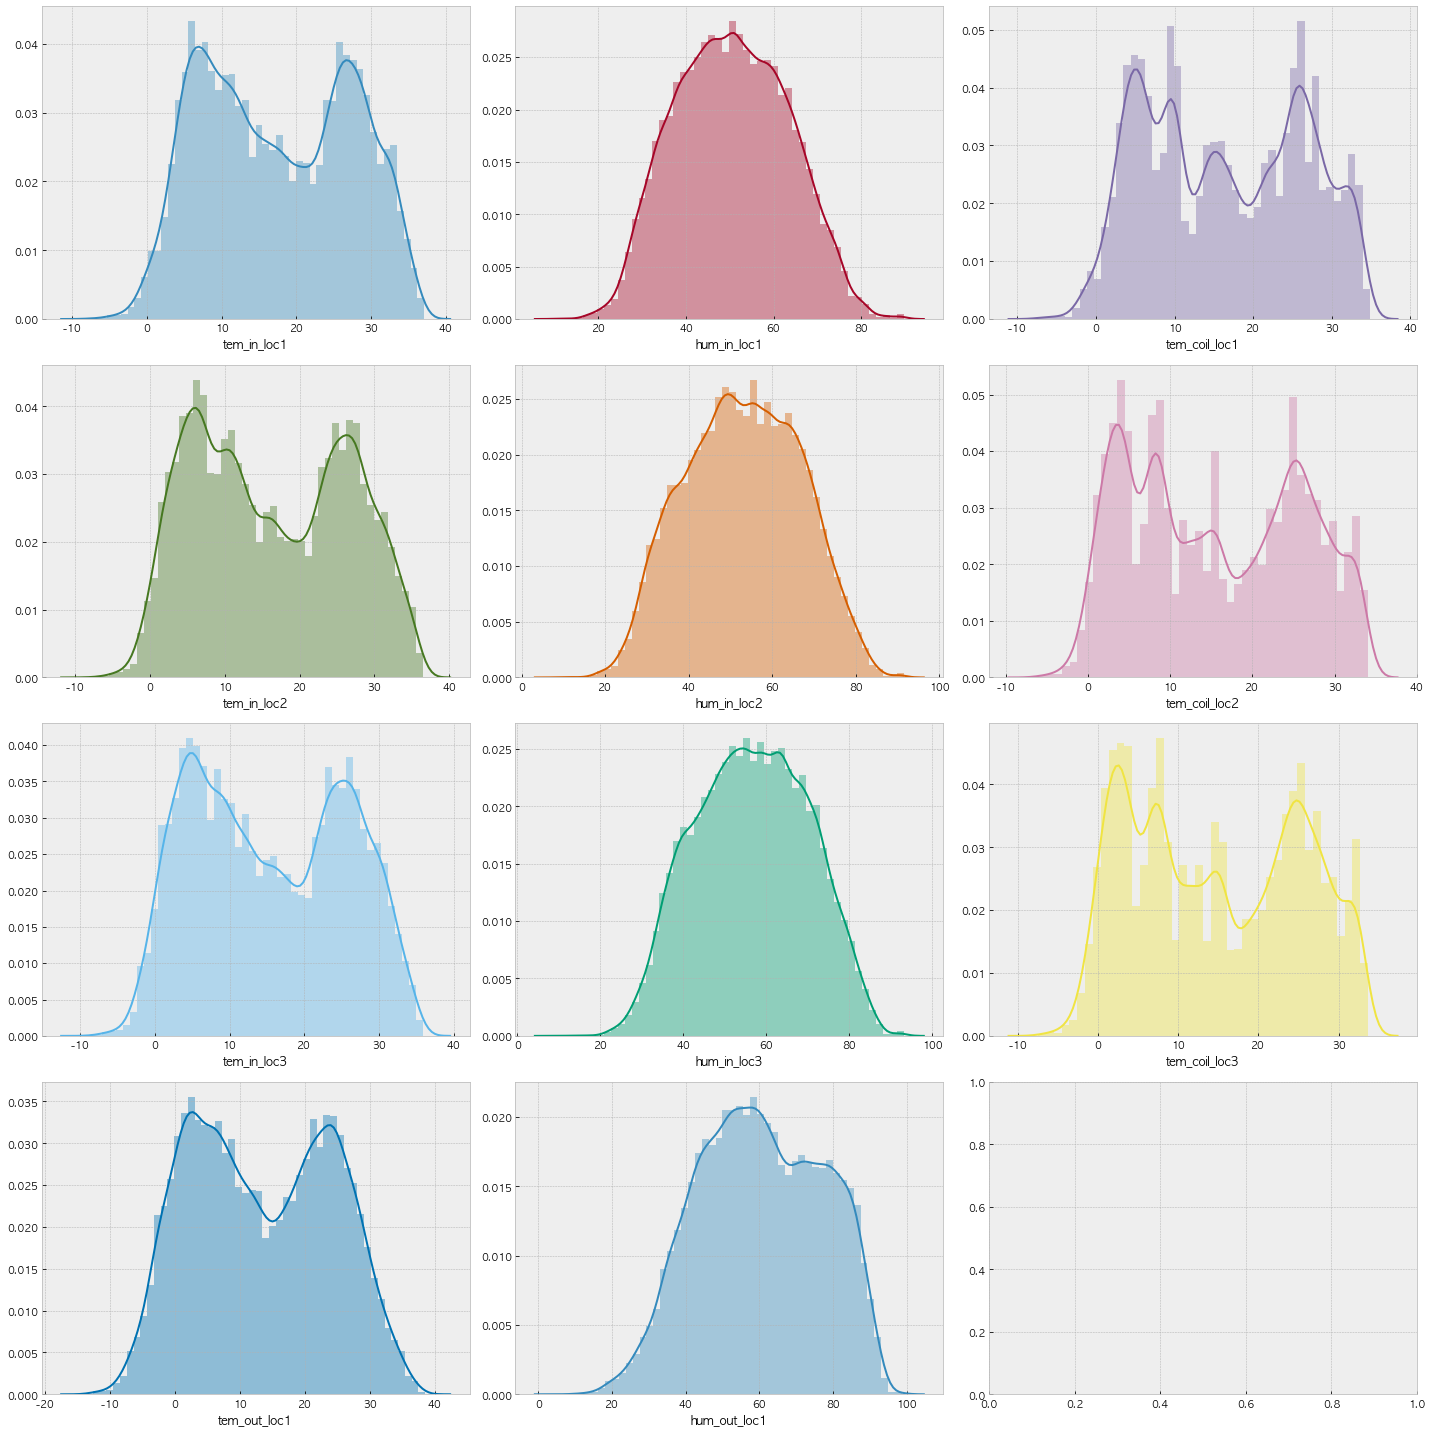

In [9]:
fig,axs=plt.subplots(4,3, figsize=(20,20))
axs=axs.flatten()
ax_idx=0
for c in plant1_var.columns:
    sns.distplot(plant1_var[c],color=next(color_cycle), ax=axs[ax_idx])
    #plant1_var[c].plot(title=c, color=next(color_cycle), ax=axs[ax_idx])
    ax_idx+=1
#plt.suptitle('tem,hum,coil dist-plot')
plt.tight_layout()
plt.show()

### 날짜별, 시간별 추이

In [17]:
# 날짜별 , 시간별 추이
plant1_train["year"] = plant1_train['mea_ddhr'].dt.year
plant1_train["month"] = plant1_train['mea_ddhr'].dt.month
plant1_train["day"] = plant1_train['mea_ddhr'].dt.day
plant1_train["hour"] =plant1_train['mea_ddhr'].dt.hour
plant1_train["minute"] =plant1_train['mea_ddhr'].dt.minute
plant1_train["second"] = plant1_train['mea_ddhr'].dt.second

**1) 공장내부 1번위치의 년/월/일/시간 별 그래프**

In [32]:
plant1_train.groupby(['year','day'])['cond_loc3'].sum()[70:120]

year  day
2018  9        0.0
      10       7.0
      11       1.0
      12       0.0
      13       8.0
      14      11.0
      15      31.0
      16      41.0
      17      32.0
      18       0.0
      19       0.0
      20       0.0
      21       0.0
      22       0.0
      23       0.0
      24       0.0
      25       0.0
      26       0.0
      27      21.0
      28       4.0
      29       1.0
      30       0.0
      31       0.0
2019  1        0.0
      2        0.0
      3      105.0
      4        0.0
      5        5.0
      6        0.0
      7        0.0
      8        0.0
      9        0.0
      10       0.0
      11       0.0
      12       0.0
      13       0.0
      14       0.0
      15       0.0
      16       0.0
      17       0.0
      18       0.0
      19       0.0
      20       0.0
      21      17.0
      22       0.0
      23       0.0
      24       0.0
      25       0.0
      26       0.0
      27       0.0
Name: cond_loc3, dtype: float64

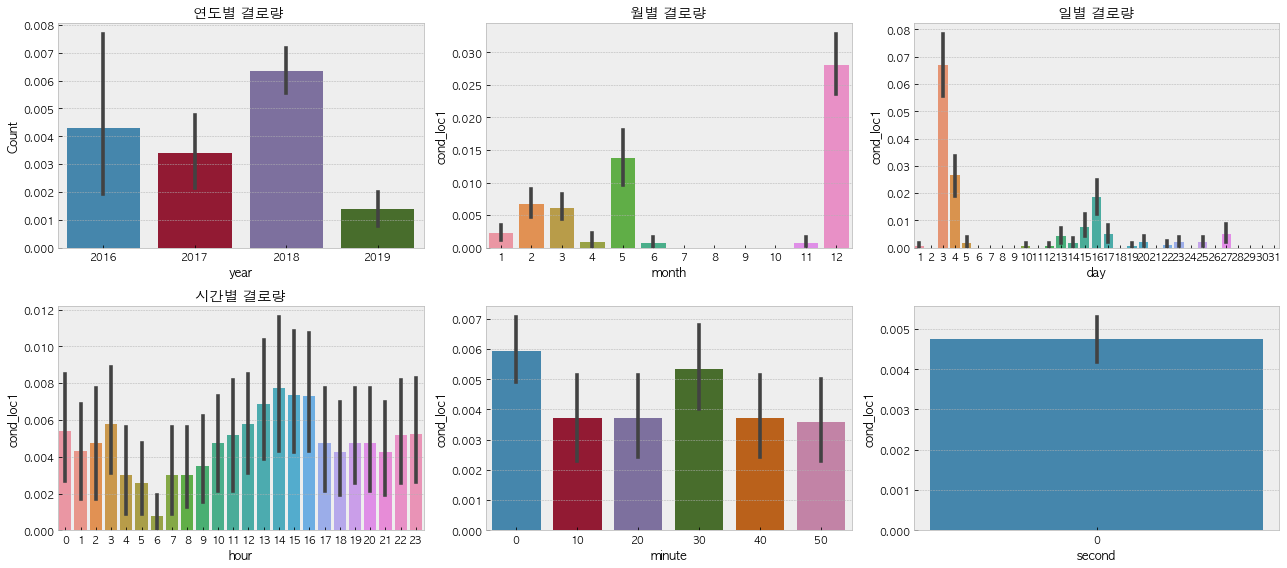

In [11]:
# 년도별, 월별 , 일별, 시간별 결로량 파악
figure, ((ax1,ax2,ax3), (ax4,ax5,ax6)) = plt.subplots(nrows=2, ncols=3)
figure.set_size_inches(18,8)

sns.barplot(data=plant1_train, x="year", y="cond_loc1", ax=ax1)
sns.barplot(data=plant1_train, x="month", y="cond_loc1", ax=ax2)
sns.barplot(data=plant1_train, x="day", y="cond_loc1", ax=ax3)
sns.barplot(data=plant1_train, x="hour", y="cond_loc1", ax=ax4)
sns.barplot(data=plant1_train, x="minute", y="cond_loc1", ax=ax5)
sns.barplot(data=plant1_train, x="second", y="cond_loc1", ax=ax6)

ax1.set(ylabel='Count',title="연도별 결로량 ")
ax2.set(xlabel='month',title="월별 결로량")
ax3.set(xlabel='day', title="일별 결로량")
ax4.set(xlabel='hour', title="시간별 결로량")
plt.tight_layout()

* 데이터 기간 : 2016-04-01 0:00 ~ 2019-03-31 23:50 
* 년도별
    * 2018년에 결로량이 가장 많음.
    * 데이터 기간을 고려해서 2019년은 적을수밖에 없고, 2016년은 4월 데이터부터 있음에도 2017년보다 결로량이 많음.
    * 따라서, 2017년은 1년치 데이터 모두 있음에도 결로량이 현저히 적은 편
* 월별 
    * 12월에 결로량이 가장 많고, 그다음으로 5월이 많음. 
    * 7월~10월은 아예 없음.
* 일별
    * 3일에 다른날보다 압도적으로 결로량이 많음..

**2) 공장내부 2번위치의 년/월/일/시간 별 그래프**

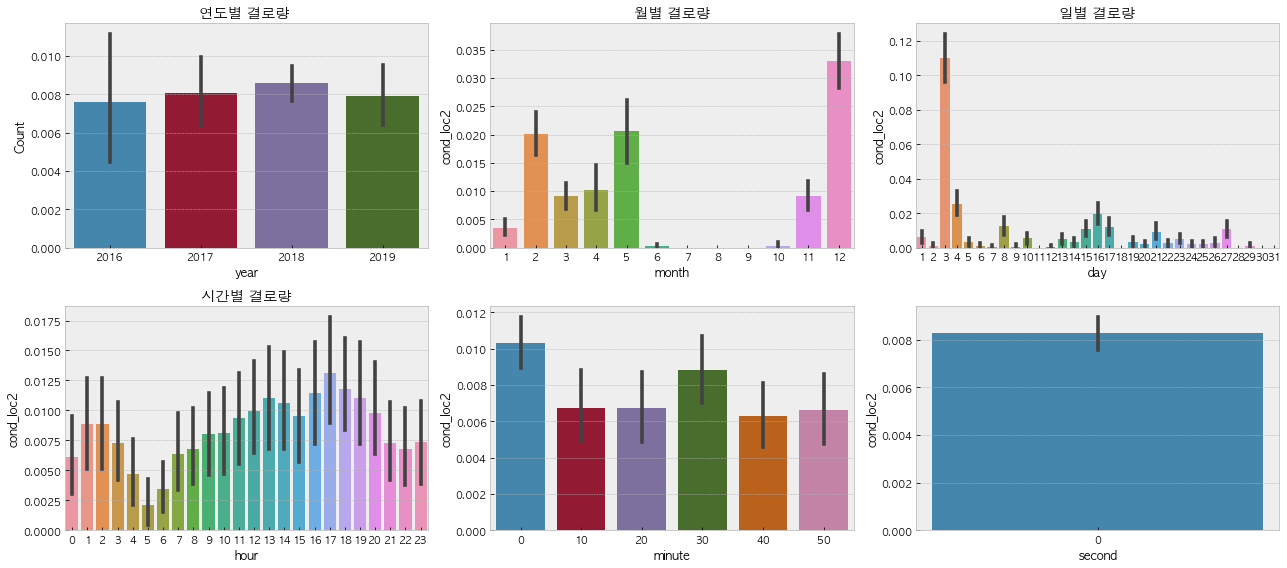

In [12]:
# 년도별, 월별 , 일별, 시간별 결로량 파악
figure, ((ax1,ax2,ax3), (ax4,ax5,ax6)) = plt.subplots(nrows=2, ncols=3)
figure.set_size_inches(18,8)

sns.barplot(data=plant1_train, x="year", y="cond_loc2", ax=ax1)
sns.barplot(data=plant1_train, x="month", y="cond_loc2", ax=ax2)
sns.barplot(data=plant1_train, x="day", y="cond_loc2", ax=ax3)
sns.barplot(data=plant1_train, x="hour", y="cond_loc2", ax=ax4)
sns.barplot(data=plant1_train, x="minute", y="cond_loc2", ax=ax5)
sns.barplot(data=plant1_train, x="second", y="cond_loc2", ax=ax6)

ax1.set(ylabel='Count',title="연도별 결로량 ")
ax2.set(xlabel='month',title="월별 결로량")
ax3.set(xlabel='day', title="일별 결로량")
ax4.set(xlabel='hour', title="시간별 결로량")
plt.tight_layout()

* 년도별
    * 공장 내부 2번위치(loc2) 는 1번위치(loc1)와 다르게 년도별로 큰 차이 없어보임
    > loc1과 loc2를 비교해봤을 때, loc1은 year별로 다른 형태를 띄므로 예측할때 loc별로 다르게 예측하고 year변수를 추가하는게 좋다고 볼수있나 ?
    
* 월별,일별,시간별로 봤을때는 공장 내부1번위치(loc1) 와 거의 유사한 형태

**3) 공장내부 3번 위치의 년/월/일/시간 별 그래프**

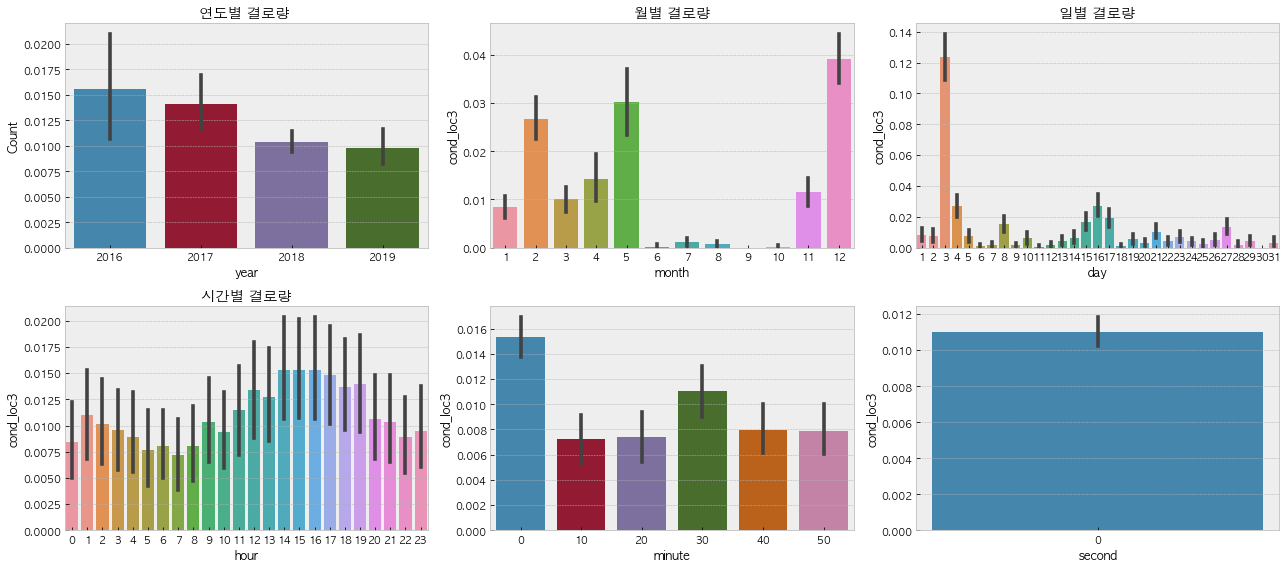

In [13]:
# 년도별, 월별 , 일별, 시간별 결로량 파악
figure, ((ax1,ax2,ax3), (ax4,ax5,ax6)) = plt.subplots(nrows=2, ncols=3)
figure.set_size_inches(18,8)

sns.barplot(data=plant1_train, x="year", y="cond_loc3", ax=ax1)
sns.barplot(data=plant1_train, x="month", y="cond_loc3", ax=ax2)
sns.barplot(data=plant1_train, x="day", y="cond_loc3", ax=ax3)
sns.barplot(data=plant1_train, x="hour", y="cond_loc3", ax=ax4)
sns.barplot(data=plant1_train, x="minute", y="cond_loc3", ax=ax5)
sns.barplot(data=plant1_train, x="second", y="cond_loc3", ax=ax6)

ax1.set(ylabel='Count',title="연도별 결로량 ")
ax2.set(xlabel='month',title="월별 결로량")
ax3.set(xlabel='day', title="일별 결로량")
ax4.set(xlabel='hour', title="시간별 결로량")
plt.tight_layout()

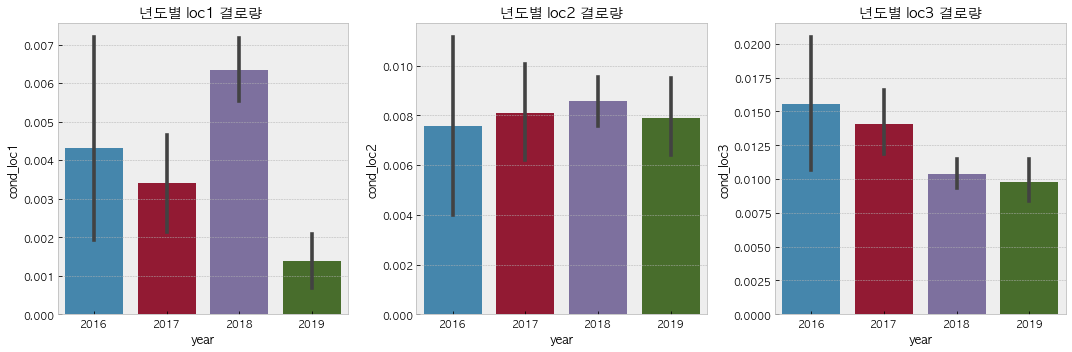

In [14]:
figure, (ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3)
figure.set_size_inches(15,5)

sns.barplot(data=plant1_train, x="year", y="cond_loc1", ax=ax1)
sns.barplot(data=plant1_train, x="year", y="cond_loc2", ax=ax2)
sns.barplot(data=plant1_train, x="year", y="cond_loc3", ax=ax3)
ax1.set(title="년도별 loc1 결로량 ")
ax2.set(title="년도별 loc2 결로량")
ax3.set( title="년도별 loc3 결로량")
plt.tight_layout()
plt.show()

**공장내부 위치(loc1,loc2,loc3) 별 결로발생, 미발생 수**

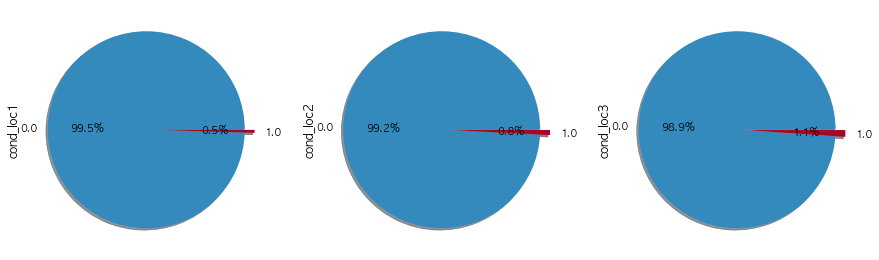

In [15]:
# pie-chart로 loc1,2,3별로 결로 비율 확인
fig, ax = plt.subplots(1,3, figsize=(15,6))
plant1_train['cond_loc1'].value_counts().plot.pie(explode=[0,0.1], autopct='%1.1f%%', ax=ax[0], shadow=True)
plant1_train['cond_loc2'].value_counts().plot.pie(explode=[0,0.1], autopct='%1.1f%%', ax=ax[1], shadow=True)
plant1_train['cond_loc3'].value_counts().plot.pie(explode=[0,0.1], autopct='%1.1f%%', ax=ax[2], shadow=True)

plt.show()

In [16]:
# loc1, loc2, loc3 각각 결로발생, 결로미발생 수 카운트
pd.concat( [plant1_train['cond_loc1'].value_counts() ,plant1_train['cond_loc2'].value_counts(),plant1_train['cond_loc3'].value_counts()],axis=1)

,cond_loc1,cond_loc2,cond_loc3
0.0,57604,58142,57959
1.0,275,487,645


* 결로가 발생하는 경우가 1%도 안됨. 따라서 예측모델 돌릴때, 결로발생(=1) 의 경우를 오버샘플링 해서 할 필요가 있어보임.

### 온도,습도, 코일온도 별 결로유무에 따른 분포

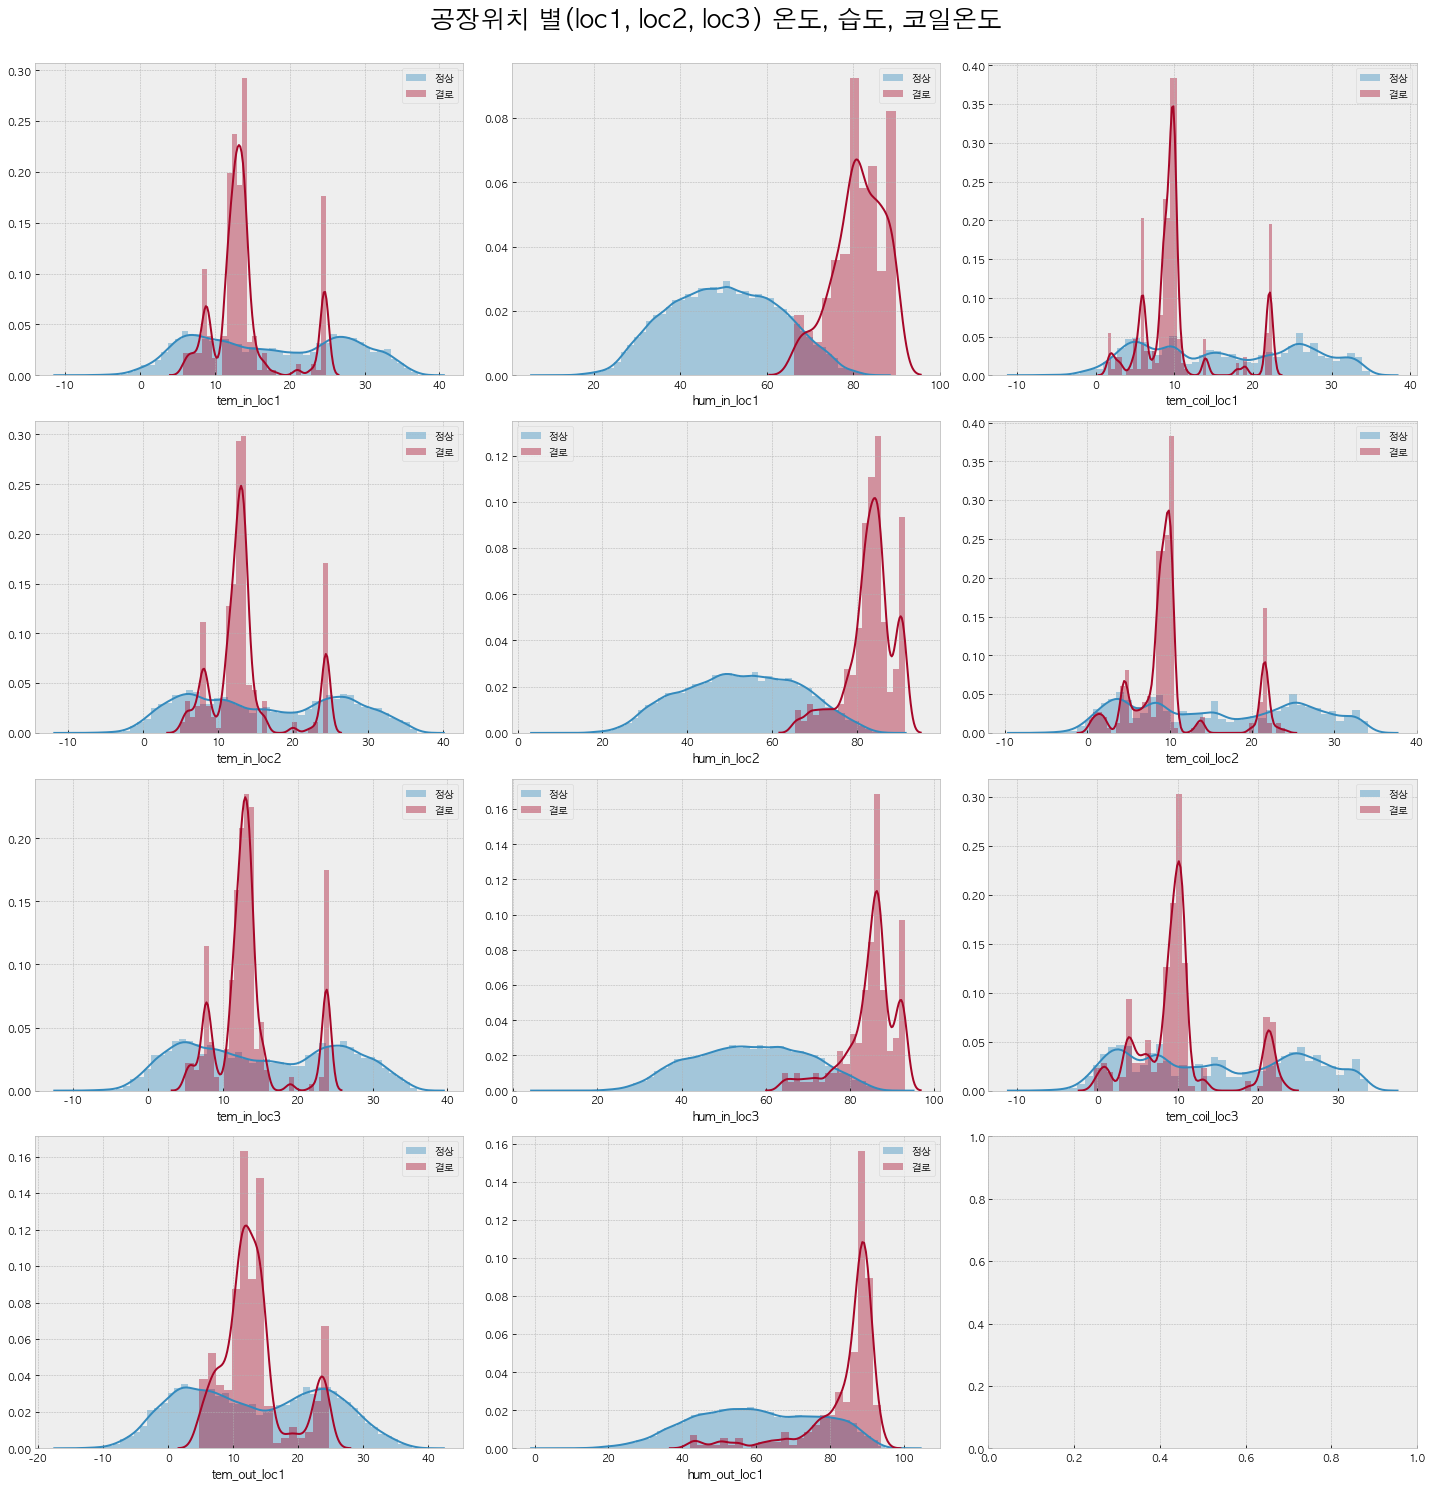

In [77]:
fig,axs=plt.subplots(4,3, figsize=(20,20))
axs=axs.flatten()
ax_idx=0

for c in plant1_var.columns:
    sns.distplot( plant1_train.query('cond_loc1==0')[c],ax=axs[ax_idx])
    sns.distplot( plant1_train.query('cond_loc1==1')[c],ax=axs[ax_idx])
    axs[ax_idx].legend(labels=['정상','결로'])
    ax_idx+=1

fig.suptitle('공장위치 별(loc1, loc2, loc3) 온도, 습도, 코일온도',
size=25,
y=1.03)
plt.tight_layout()
plt.show()

정상일때보다 결로현상이 나타났을 때 값이 더 튀는 형태 보임. <br>
* 온도와 코일온도는 대체로 중앙에 밀집되어있는 형태
* 습도는 우측으로 치우쳐진 형태

### 변수 간 상관관계 
* 다중공선성 확인 필요

In [20]:
corrMatt=plant1_var.corr()
mask=np.array(corrMatt)
mask[np.tril_indices_from(mask)] = False

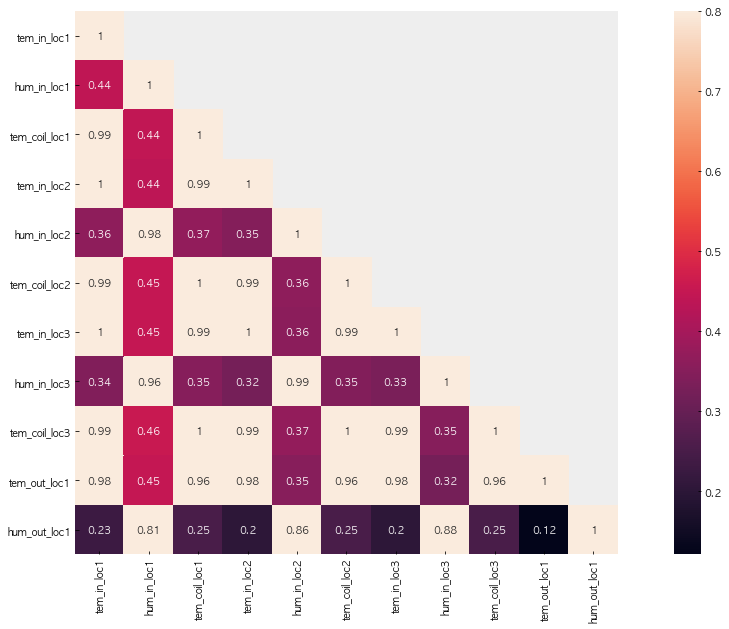

In [21]:
fig, ax = plt.subplots()
fig.set_size_inches(20,10)
sns.heatmap(corrMatt, mask=mask,vmax=.8, square=True,annot=True)

------------------------------------------------------------------------------------------
## 2) plant2 데이터탐색

In [111]:
plant2_train=pd.read_csv('./data/plant2_train.csv',index_col=[0],parse_dates=['plant2_train.mea_ddhr'])
plant2_train.columns=plant2_train.columns.str.slice(13)

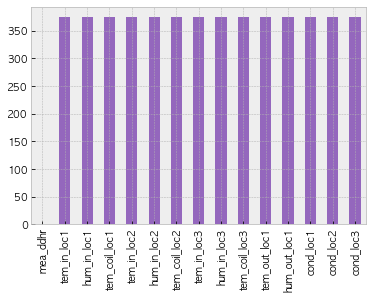

In [112]:
plant2_train.isnull().sum().plot.bar(color=color[4])
plt.show()

**결측치 수, 결측치 비율**

In [113]:
missing_values=pd.concat([plant2_train.isnull().sum(), 
                          round((plant2_train.isnull().sum()/plant2_train.shape[0])*100,2).to_frame().rename(columns={0:'ratio'})], axis=1)
missing_values.columns=['missing_num','ratio(%)']
missing_values

,missing_num,ratio(%)
mea_ddhr,0,0.00
tem_in_loc1,374,0.64
hum_in_loc1,374,0.64
tem_coil_loc1,374,0.64
tem_in_loc2,374,0.64
hum_in_loc2,374,0.64
tem_coil_loc2,374,0.64
tem_in_loc3,374,0.64
hum_in_loc3,374,0.64
tem_coil_loc3,374,0.64


In [97]:
# 날짜별 , 시간별 추이
plant2_train["year"] = plant2_train['mea_ddhr'].dt.year
plant2_train["month"] = plant2_train['mea_ddhr'].dt.month
plant2_train["day"] = plant2_train['mea_ddhr'].dt.day
plant2_train["hour"] =plant2_train['mea_ddhr'].dt.hour
plant2_train["minute"] =plant2_train['mea_ddhr'].dt.minute
plant2_train["second"] = plant2_train['mea_ddhr'].dt.second

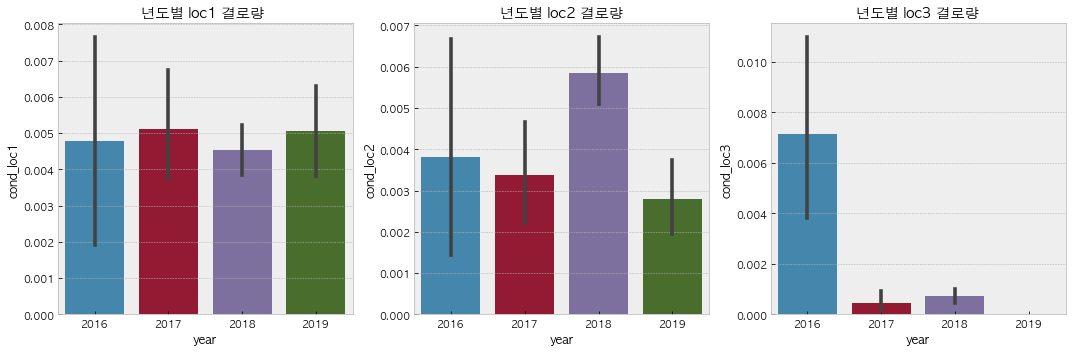

In [99]:
figure, (ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3)
figure.set_size_inches(15,5)

sns.barplot(data=plant2_train, x="year", y="cond_loc1", ax=ax1)
sns.barplot(data=plant2_train, x="year", y="cond_loc2", ax=ax2)
sns.barplot(data=plant2_train, x="year", y="cond_loc3", ax=ax3)
ax1.set(title="년도별 loc1 결로량 ")
ax2.set(title="년도별 loc2 결로량")
ax3.set( title="년도별 loc3 결로량")
plt.tight_layout()
plt.show()

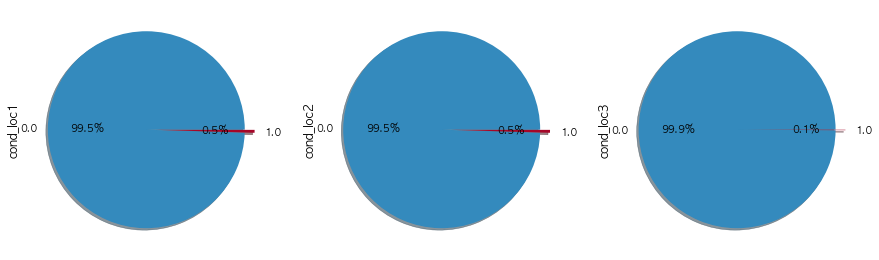

In [100]:
# pie-chart로 loc1,2,3별로 결로 비율 확인
fig, ax = plt.subplots(1,3, figsize=(15,6))
plant2_train['cond_loc1'].value_counts().plot.pie(explode=[0,0.1], autopct='%1.1f%%', ax=ax[0], shadow=True)
plant2_train['cond_loc2'].value_counts().plot.pie(explode=[0,0.1], autopct='%1.1f%%', ax=ax[1], shadow=True)
plant2_train['cond_loc3'].value_counts().plot.pie(explode=[0,0.1], autopct='%1.1f%%', ax=ax[2], shadow=True)

plt.show()

In [101]:
# loc1, loc2, loc3 각각 결로발생, 결로미발생 수 카운트
pd.concat( [plant2_train['cond_loc1'].value_counts() ,plant2_train['cond_loc2'].value_counts(),plant2_train['cond_loc3'].value_counts()],axis=1)

,cond_loc1,cond_loc2,cond_loc3
0.0,58141,58141,58374
1.0,277,277,44


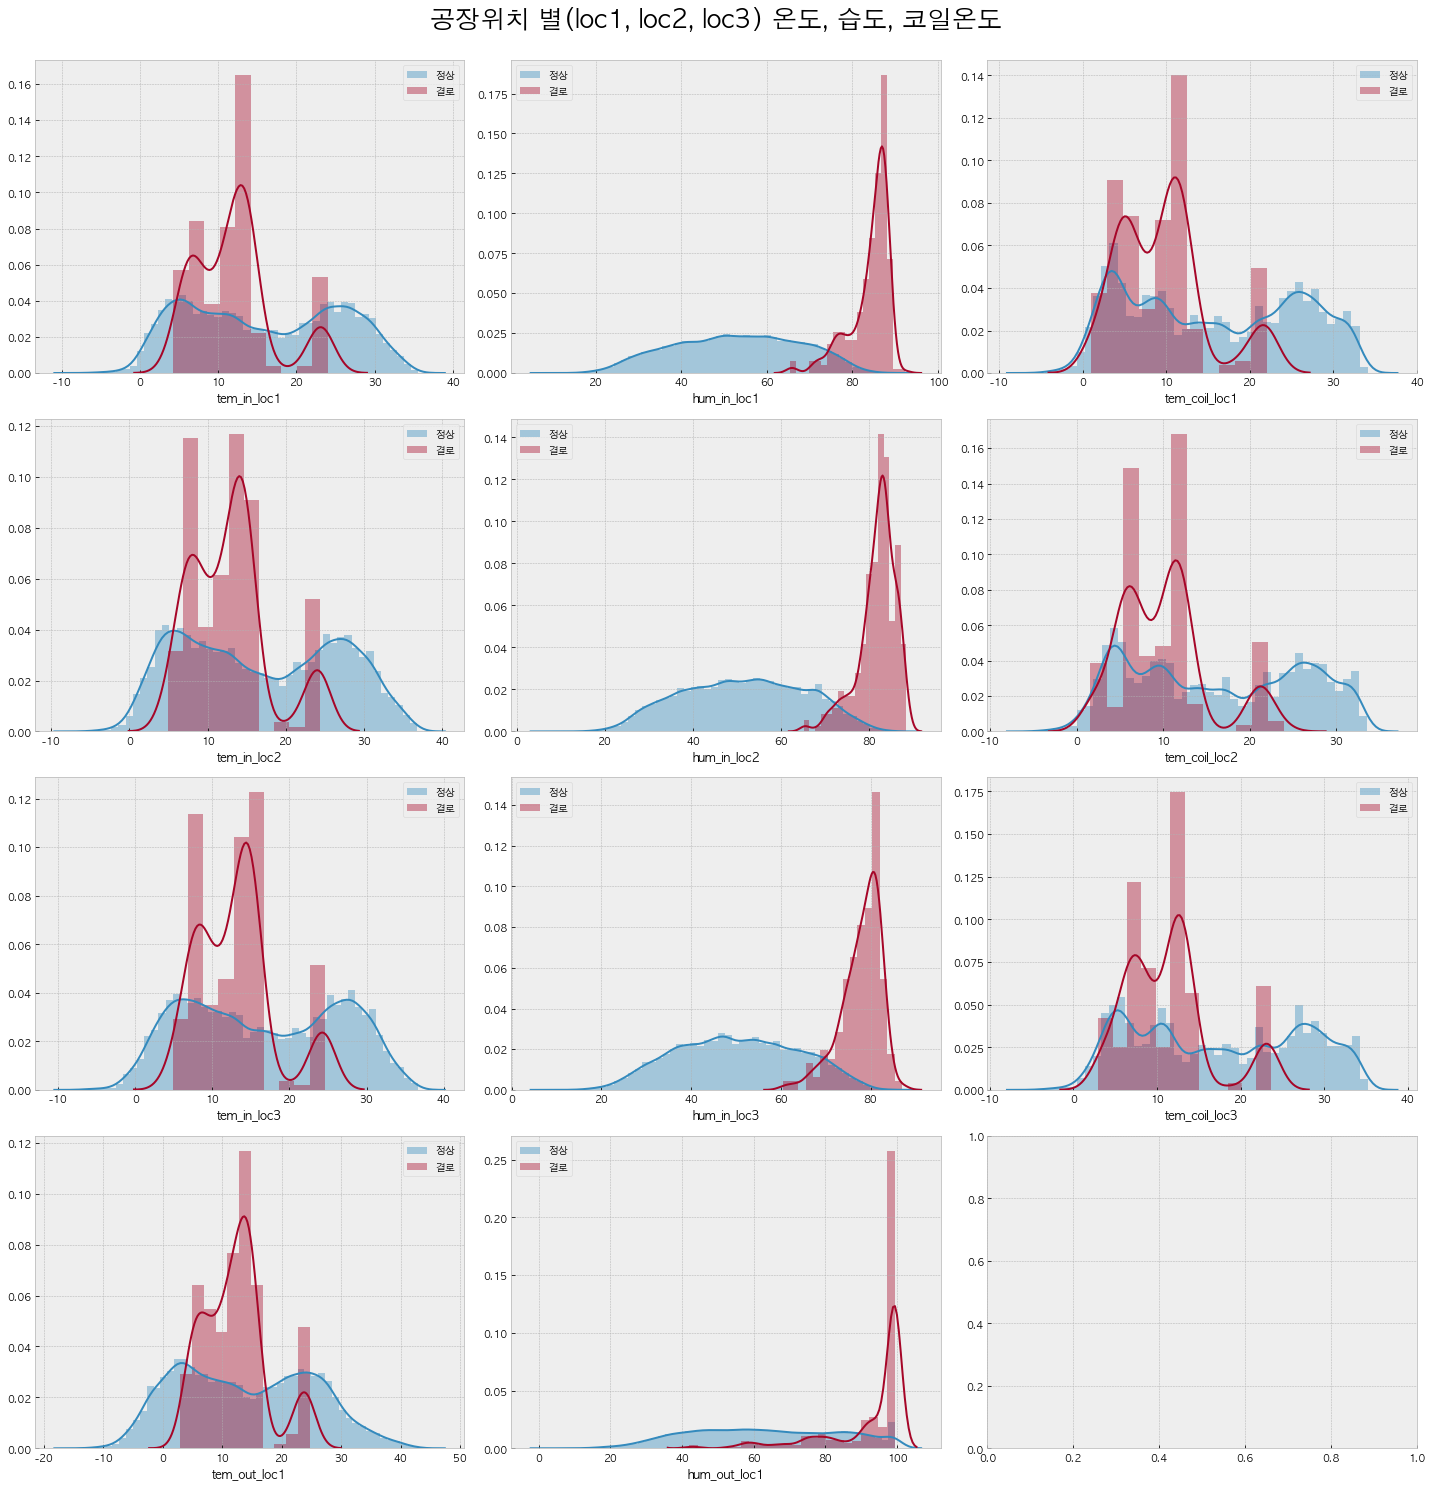

In [102]:
fig,axs=plt.subplots(4,3, figsize=(20,20))
axs=axs.flatten()
ax_idx=0

for c in plant2_var.columns:
    sns.distplot( plant2_train.query('cond_loc1==0')[c],ax=axs[ax_idx])
    sns.distplot( plant2_train.query('cond_loc1==1')[c],ax=axs[ax_idx])
    axs[ax_idx].legend(labels=['정상','결로'])
    ax_idx+=1

fig.suptitle('공장위치 별(loc1, loc2, loc3) 온도, 습도, 코일온도',
size=25,
y=1.03)
plt.tight_layout()
plt.show()